In [1]:
%matplotlib inline

# install pillow
!pip install Pillow -U

# # download and unzip dataset o train
# !wget http://images.cocodataset.org/zips/val2014.zip
# !mkdir train
# %cd /content/train
# !unzip -qq /content/val2014.zip
# %cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

     |████████████████████████████████| 4.3 MB 32.3 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


--2022-05-03 14:32:41--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  14.6MB/s    in 38s     

2022-05-03 14:33:20 (13.9 MB/s) - ‘vgg16-00b39a1b.pth’ saved [553451520/553451520]



# Style Transfer Training

## Import Library

In [2]:
import torch
import torch.nn as nn
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

# get utils functions
# from utils import grammatrix, loss_of_style, loss_of_content, content_transform, detransform_content, rescale

from PIL import Image
import cv2
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg16_fe as vgg # this is used to extract features
import custom_model
import utils
# import vgg16 as vgg_style


In [3]:
!sh download_data.sh

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Trained on TinyImageNet dataset for different styles

## Udnie

In [10]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = 'tiny-224/train'
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/udnie.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "udnie/models/"
SAVE_IMAGE_PATH = "udnie/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [13]:
def train():
    # seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # get the device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # load the training dataset
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # load the models and start training :)
    model = custom_model.CustomModel().to(device)
    vgg16_fe = vgg.VGG16('/content/vgg16-00b39a1b.pth').to(device)

    # get style features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    # load the style image
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    # convert style image to tensor
    style_tensor = utils.itot(style_image).to(device)
    # add imagenet mean
    style_tensor = style_tensor.add(imagenet_neg_mean)

    B, C, H, W = style_tensor.shape
    # get the features of the style image
    style_features = vgg16_fe(style_tensor.expand([BATCH_SIZE, C, H, W]))

    # get the gram matrix of the style image
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    # Optimizer settings
    optimizer = optim.Adam(model.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()

    # training loop
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # free up unnecessary memory of cuda
            torch.cuda.empty_cache()

            # zero the gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = model(content_batch)
            content_features = vgg16_fe(content_batch.add(imagenet_neg_mean))
            generated_features = vgg16_fe(generated_batch.add(imagenet_neg_mean))

            # Calculate content loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(generated_features['relu1_2'], content_features['relu1_2'])            
            batch_content_loss_sum += content_loss

            # Calculate style loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()

            # Calculate total loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backpropagation
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(model.state_dict(), checkpoint_path)
                
                print("Saved CustomModel checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0) # clone to save inplace errors
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                utils.show(sample_image)
                print("Saved sample stylized image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)
            
            # increment batch count
            batch_count += 1
    
    stop_time = time.time()
    # Print loss histories
    print("Done Training the Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 

    # Save TransformerNetwork weights
    model.eval()
    model.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving Custom Model weights at {}".format(final_path))
    torch.save(model.state_dict(), final_path)
    print("Done saving final model")

    # Plot Loss Histories
    if (PLOT_LOSS):
        utils.plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)


========Epoch 1/1========
========Iteration 1/25000========
	Content Loss:	792234.38
	Style Loss:	20193196.00
	Total Loss:	20985430.00
Time elapsed:	0.42380237579345703 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_0.pth


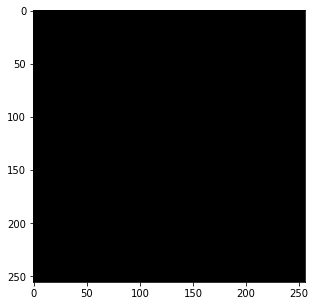

Saved sample stylized image at udnie/images/sample0_0.png
========Iteration 501/25000========
	Content Loss:	570280.25
	Style Loss:	2664404.96
	Total Loss:	3234685.38
Time elapsed:	125.64202976226807 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_500.pth


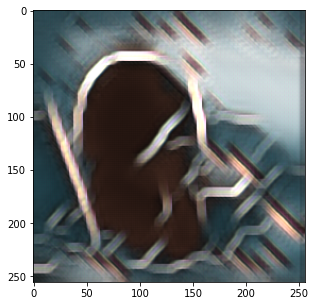

Saved sample stylized image at udnie/images/sample0_500.png
========Iteration 1001/25000========
	Content Loss:	534084.44
	Style Loss:	1594137.00
	Total Loss:	2128221.55
Time elapsed:	251.6615879535675 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_1000.pth


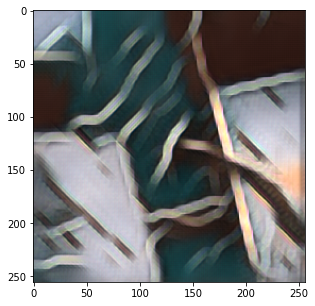

Saved sample stylized image at udnie/images/sample0_1000.png
========Iteration 1501/25000========
	Content Loss:	514720.34
	Style Loss:	1182547.44
	Total Loss:	1697267.51
Time elapsed:	378.56447672843933 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_1500.pth


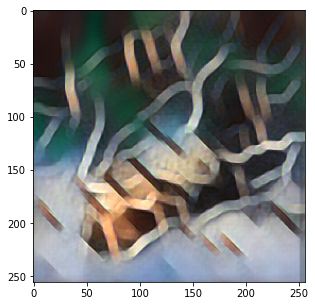

Saved sample stylized image at udnie/images/sample0_1500.png
========Iteration 2001/25000========
	Content Loss:	498994.41
	Style Loss:	958512.50
	Total Loss:	1457506.32
Time elapsed:	505.9184510707855 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_2000.pth


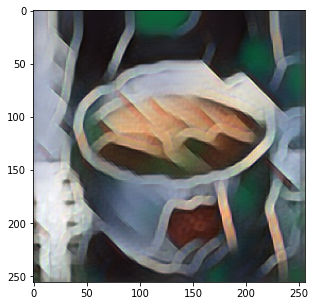

Saved sample stylized image at udnie/images/sample0_2000.png
========Iteration 2501/25000========
	Content Loss:	484807.97
	Style Loss:	816627.08
	Total Loss:	1301434.46
Time elapsed:	634.1186306476593 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_2500.pth


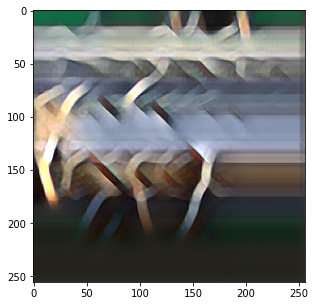

Saved sample stylized image at udnie/images/sample0_2500.png
========Iteration 3001/25000========
	Content Loss:	474651.91
	Style Loss:	718439.95
	Total Loss:	1193090.84
Time elapsed:	761.8906648159027 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_3000.pth


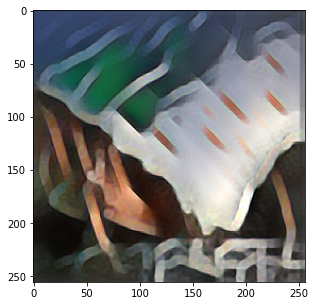

Saved sample stylized image at udnie/images/sample0_3000.png
========Iteration 3501/25000========
	Content Loss:	467158.19
	Style Loss:	645462.97
	Total Loss:	1112620.52
Time elapsed:	889.8905112743378 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_3500.pth


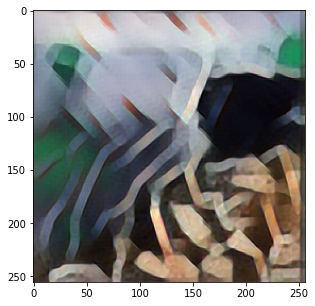

Saved sample stylized image at udnie/images/sample0_3500.png
========Iteration 4001/25000========
	Content Loss:	461355.34
	Style Loss:	588700.22
	Total Loss:	1050054.95
Time elapsed:	1017.4255518913269 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_4000.pth


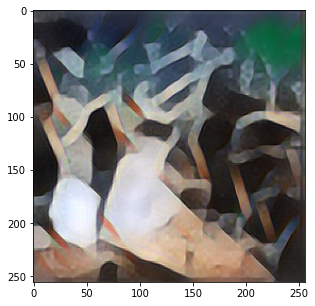

Saved sample stylized image at udnie/images/sample0_4000.png
========Iteration 4501/25000========
	Content Loss:	457857.19
	Style Loss:	543586.01
	Total Loss:	1001442.17
Time elapsed:	1145.5213811397552 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_4500.pth


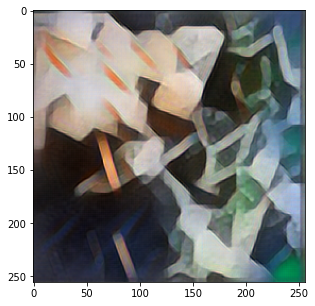

Saved sample stylized image at udnie/images/sample0_4500.png
========Iteration 5001/25000========
	Content Loss:	451775.03
	Style Loss:	506256.13
	Total Loss:	958029.93
Time elapsed:	1272.8976962566376 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_5000.pth


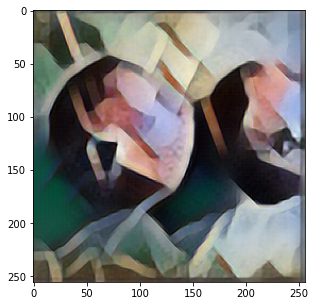

Saved sample stylized image at udnie/images/sample0_5000.png
========Iteration 5501/25000========
	Content Loss:	447149.06
	Style Loss:	475123.53
	Total Loss:	922270.89
Time elapsed:	1399.8348371982574 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_5500.pth


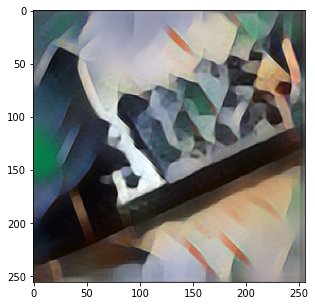

Saved sample stylized image at udnie/images/sample0_5500.png
========Iteration 6001/25000========
	Content Loss:	442390.66
	Style Loss:	448595.99
	Total Loss:	890985.26
Time elapsed:	1526.6937279701233 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_6000.pth


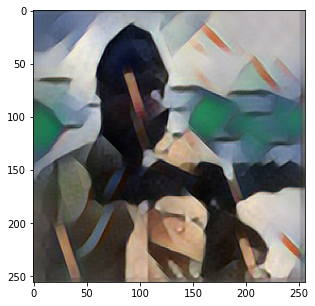

Saved sample stylized image at udnie/images/sample0_6000.png
========Iteration 6501/25000========
	Content Loss:	438706.19
	Style Loss:	425995.47
	Total Loss:	864700.56
Time elapsed:	1653.2020695209503 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_6500.pth


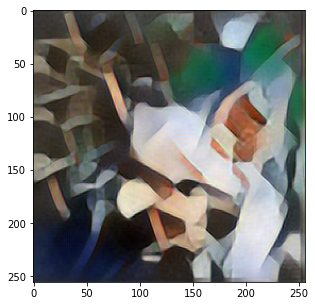

Saved sample stylized image at udnie/images/sample0_6500.png
========Iteration 7001/25000========
	Content Loss:	435446.44
	Style Loss:	406378.65
	Total Loss:	841824.08
Time elapsed:	1779.8292763233185 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_7000.pth


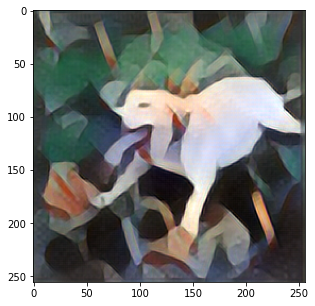

Saved sample stylized image at udnie/images/sample0_7000.png
========Iteration 7501/25000========
	Content Loss:	432877.06
	Style Loss:	388964.76
	Total Loss:	821840.99
Time elapsed:	1906.8041970729828 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_7500.pth


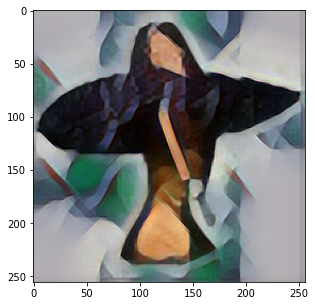

Saved sample stylized image at udnie/images/sample0_7500.png
========Iteration 8001/25000========
	Content Loss:	430549.12
	Style Loss:	373590.12
	Total Loss:	804138.30
Time elapsed:	2033.2642369270325 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_8000.pth


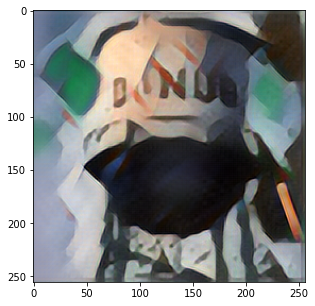

Saved sample stylized image at udnie/images/sample0_8000.png
========Iteration 8501/25000========
	Content Loss:	427977.56
	Style Loss:	359929.39
	Total Loss:	787906.29
Time elapsed:	2159.440521001816 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_8500.pth


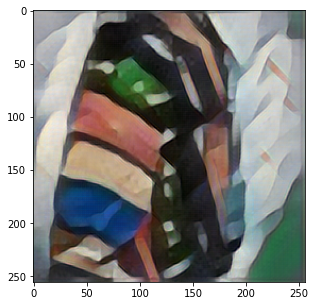

Saved sample stylized image at udnie/images/sample0_8500.png
========Iteration 9001/25000========
	Content Loss:	424881.94
	Style Loss:	347537.60
	Total Loss:	772418.60
Time elapsed:	2285.727102994919 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_9000.pth


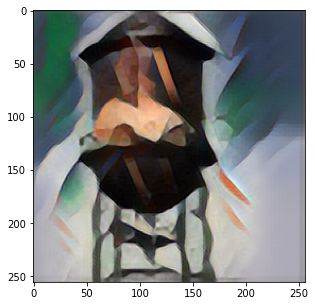

Saved sample stylized image at udnie/images/sample0_9000.png
========Iteration 9501/25000========
	Content Loss:	422554.31
	Style Loss:	336435.55
	Total Loss:	758989.06
Time elapsed:	2411.7183907032013 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_9500.pth


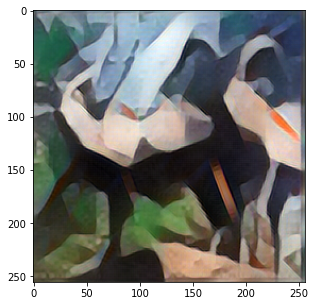

Saved sample stylized image at udnie/images/sample0_9500.png
========Iteration 10001/25000========
	Content Loss:	420440.41
	Style Loss:	326379.12
	Total Loss:	746818.68
Time elapsed:	2537.8326048851013 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_10000.pth


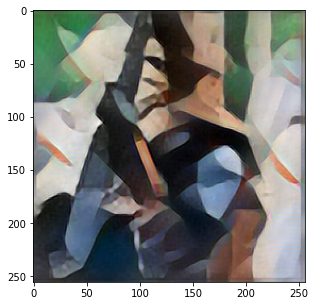

Saved sample stylized image at udnie/images/sample0_10000.png
========Iteration 10501/25000========
	Content Loss:	418298.59
	Style Loss:	317167.48
	Total Loss:	735464.86
Time elapsed:	2664.0261447429657 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_10500.pth


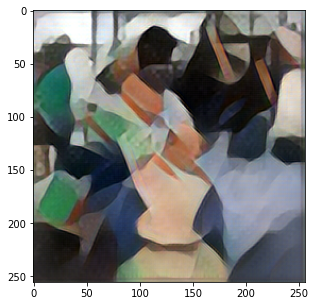

Saved sample stylized image at udnie/images/sample0_10500.png
========Iteration 11001/25000========
	Content Loss:	416288.56
	Style Loss:	308766.80
	Total Loss:	725053.75
Time elapsed:	2789.974589109421 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_11000.pth


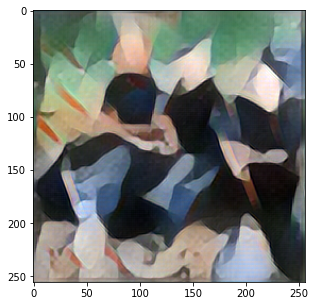

Saved sample stylized image at udnie/images/sample0_11000.png
========Iteration 11501/25000========
	Content Loss:	414633.06
	Style Loss:	301008.24
	Total Loss:	715640.24
Time elapsed:	2915.9036045074463 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_11500.pth


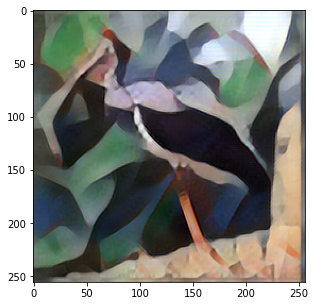

Saved sample stylized image at udnie/images/sample0_11500.png
========Iteration 12001/25000========
	Content Loss:	412535.34
	Style Loss:	293843.27
	Total Loss:	706377.71
Time elapsed:	3041.7734088897705 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_12000.pth


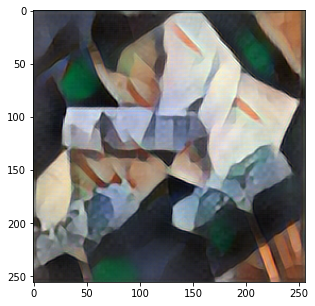

Saved sample stylized image at udnie/images/sample0_12000.png
========Iteration 12501/25000========
	Content Loss:	410997.69
	Style Loss:	287196.03
	Total Loss:	698192.44
Time elapsed:	3167.7710676193237 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_12500.pth


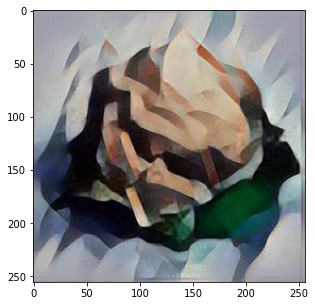

Saved sample stylized image at udnie/images/sample0_12500.png
========Iteration 13001/25000========
	Content Loss:	409868.00
	Style Loss:	281025.25
	Total Loss:	690892.33
Time elapsed:	3293.463620901108 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_13000.pth


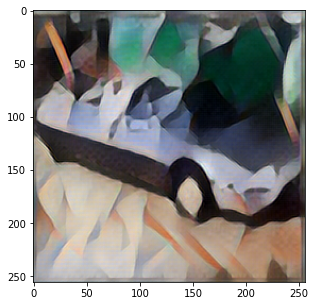

Saved sample stylized image at udnie/images/sample0_13000.png
========Iteration 13501/25000========
	Content Loss:	408279.81
	Style Loss:	275246.49
	Total Loss:	683525.06
Time elapsed:	3419.3693075180054 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_13500.pth


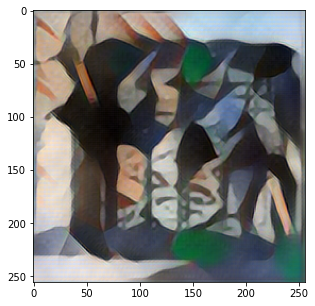

Saved sample stylized image at udnie/images/sample0_13500.png
========Iteration 14001/25000========
	Content Loss:	407011.97
	Style Loss:	269788.92
	Total Loss:	676799.82
Time elapsed:	3545.0746290683746 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_14000.pth


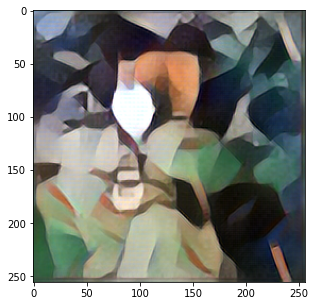

Saved sample stylized image at udnie/images/sample0_14000.png
========Iteration 14501/25000========
	Content Loss:	405631.56
	Style Loss:	264760.75
	Total Loss:	670391.63
Time elapsed:	3671.089051246643 seconds
Saved CustomModel checkpoint file at udnie/models/checkpoint_14500.pth


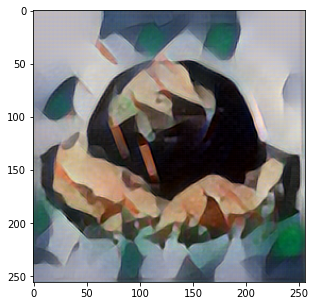

Saved sample stylized image at udnie/images/sample0_14500.png


In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r udnie/models/ /content/gdrive/My\ Drive/tinyimagenet_custom/udnie/
# copy the images folder to the folder in the google drive
!cp -r udnie/images/ /content/gdrive/My\ Drive/tinyimagenet_custom/udnie/

## Rain Princess

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = 'tiny-224/train'
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/rain_princess.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "rain_princess/models/"
SAVE_IMAGE_PATH = "rain_princess/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r udnie/models/ /content/gdrive/My\ Drive/tinyimagenet_custom/rain_princess/
# copy the images folder to the folder in the google drive
!cp -r udnie/images/ /content/gdrive/My\ Drive/tinyimagenet_custom/rain_princess/

## The Scream

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = 'tiny-224/train'
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/the_scream.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "the_scream/models/"
SAVE_IMAGE_PATH = "the_scream/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r udnie/models/ /content/gdrive/My\ Drive/tinyimagenet_custom/the_scream/
# copy the images folder to the folder in the google drive
!cp -r udnie/images/ /content/gdrive/My\ Drive/tinyimagenet_custom/the_scream/

## The Shipwreck

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = 'tiny-224/train'
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/the_shipwreck.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "the_shipwreck/models/"
SAVE_IMAGE_PATH = "the_shipwreck/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r udnie/models/ /content/gdrive/My\ Drive/tinyimagenet_custom/the_shipwreck/
# copy the images folder to the folder in the google drive
!cp -r udnie/images/ /content/gdrive/My\ Drive/tinyimagenet_custom/the_shipwreck/

## Wave

In [ ]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = 'tiny-224/train'
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/wave.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "wave/models/"
SAVE_IMAGE_PATH = "wave/images/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [ ]:
train()

In [ ]:
# copy the models folder to the folder in the google drive
!cp -r udnie/models/ /content/gdrive/My\ Drive/tinyimagenet_custom/wave/
# copy the images folder to the folder in the google drive
!cp -r udnie/images/ /content/gdrive/My\ Drive/tinyimagenet_custom/wave/